# knee osteoarthritis classification
sliding window with overlapping 90%

## import library

In [1]:
import pandas as pd
import numpy as np
import pickle 
import os 
import operator
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.metrics import  accuracy_score,f1_score,classification_report
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC,LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import CategoricalNB,GaussianNB,MultinomialNB,BernoulliNB
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import warnings 
warnings.filterwarnings("ignore")

## Get data from google drive

In [2]:
# get data from google drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# loading data as a pandas dataframe
df = pd.read_pickle('/content/drive/MyDrive/datapkle/structure_dataset500.pkl')

Value counts for each class:

1    1692
0     930
Name: target, dtype: int64



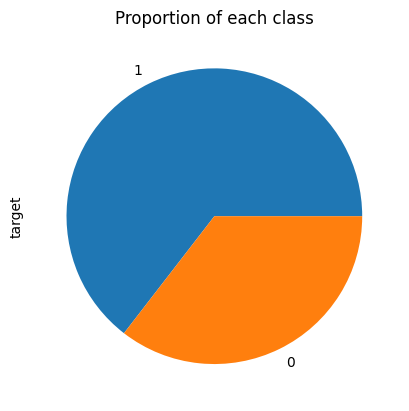

In [4]:
print(f"Value counts for each class:\n\n{df.target.value_counts()}\n")

# Display pie chart to visually check the proportion
df.target.value_counts().plot.pie(y='label', title='Proportion of each class')
plt.show()

In [9]:
# imbalanced data to trim the abnormal data to balance dataset 
print('shape before trim abnormal class',df.shape)
ab = df.iloc[:1692,:]
nr = df.iloc[1692:,:]
# ab.shape , nr.shape
ab = df.iloc[:930,:]
New_df = pd.concat([ab,nr])
print('shape after trim abnormal class',New_df.shape)

shape before trim abnormal class (2622, 26)
shape after trim abnormal class (1860, 26)


In [15]:
New_df.dtypes

feature_one       float64
feature_two       float64
feature_three     float64
feature_four      float64
feature_five      float64
feature2_one      float64
feature2_two      float64
feature2_three    float64
feature2_four     float64
feature2_five     float64
feature3_one      float64
feature3_two      float64
feature3_three    float64
feature3_four     float64
feature3_five     float64
feature4_one      float64
feature4_two      float64
feature4_three    float64
feature4_four     float64
feature4_five     float64
feature5_one      float64
feature5_two      float64
feature5_three    float64
feature5_four     float64
feature5_five     float64
target              int64
dtype: object

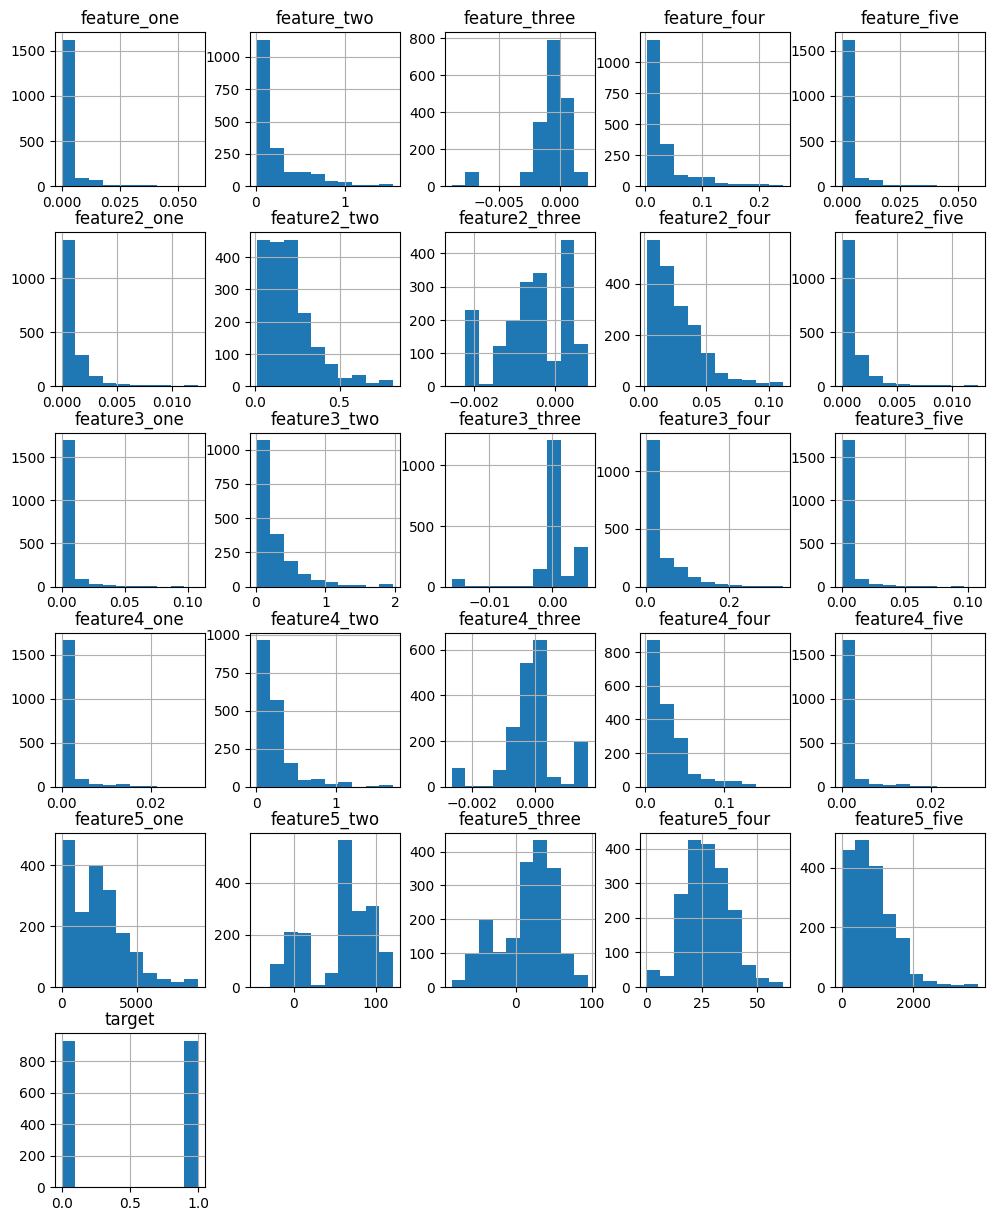

In [16]:
New_df.hist(figsize = (12, 15));

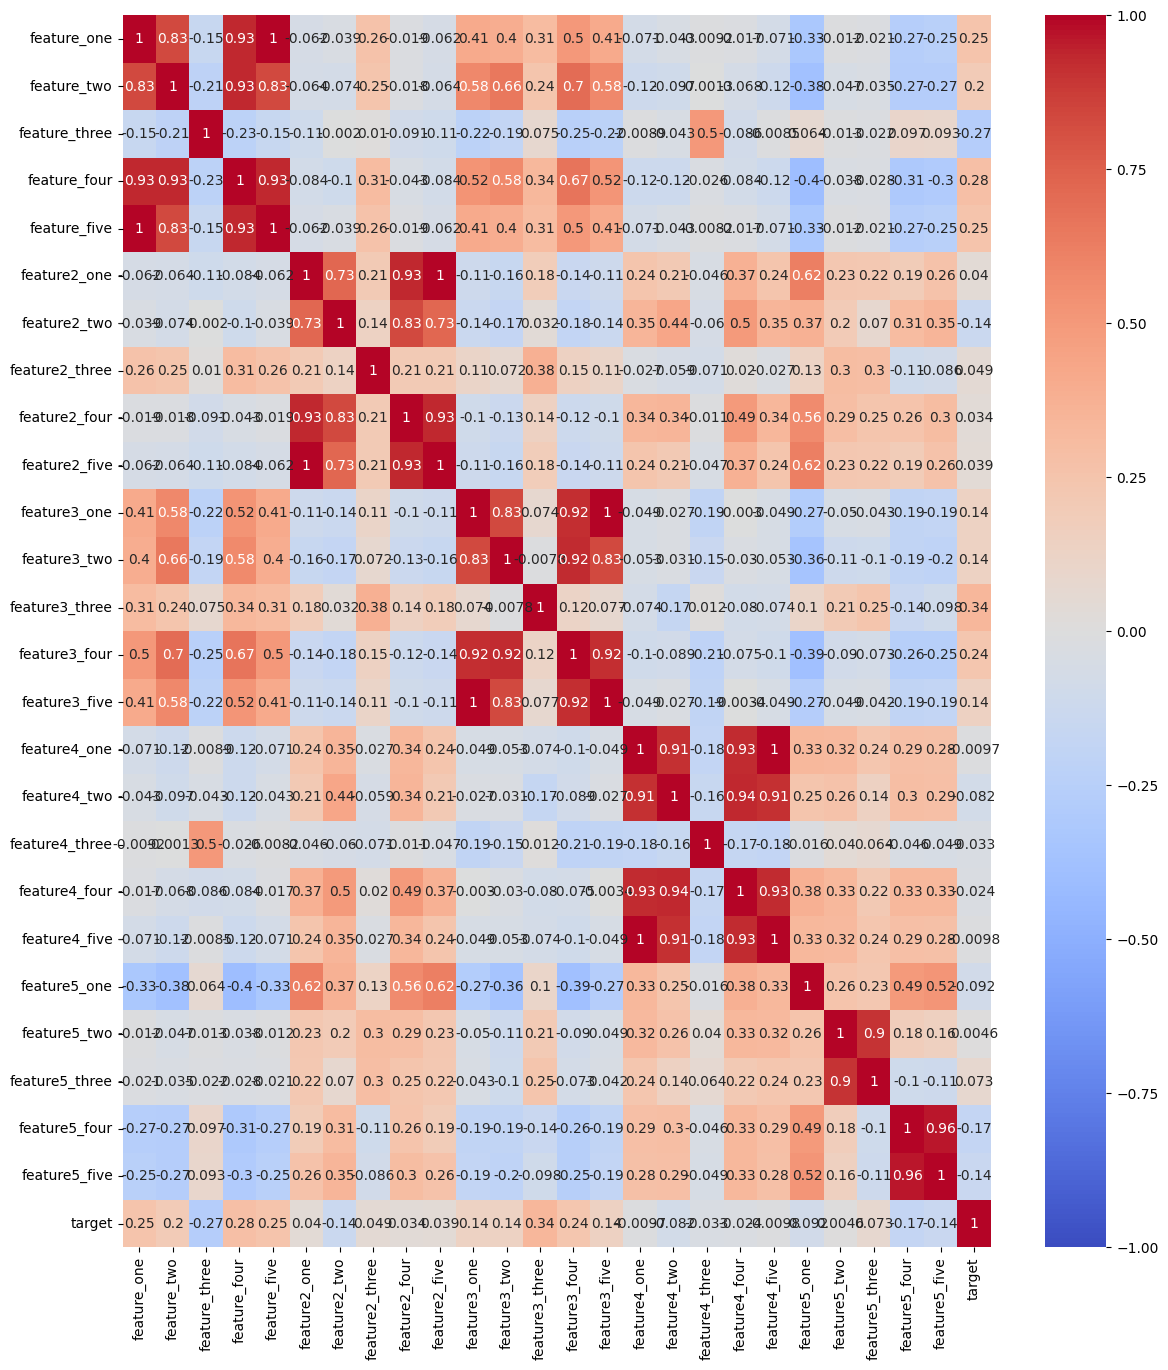

In [17]:
import seaborn as sns 
corr = New_df.corr()
plt.figure(figsize=(14,16))
sns.heatmap(corr, annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm'); # greens

In [18]:
df1 = New_df.sample(frac=1)

In [19]:
df1 = df1.reset_index()
df1

,index,feature_one,feature_two,feature_three,feature_four,feature_five,feature2_one,feature2_two,feature2_three,feature2_four,...,feature4_two,feature4_three,feature4_four,feature4_five,feature5_one,feature5_two,feature5_three,feature5_four,feature5_five,target
0,846,0.000135,0.0637,-0.001299,0.011532,0.000133,0.011582,0.3645,0.000243,0.107628,...,0.1342,-0.000053,0.037596,0.001413,8983.823104,96.2,94.77988,0.773027,0.597571,1
1,565,0.001593,0.1950,0.000168,0.039913,0.001593,0.000640,0.1455,0.000498,0.025288,...,0.0510,-0.000098,0.003151,0.000010,2266.390532,71.3,37.41648,29.437576,866.570871,0
2,1060,0.008411,0.6172,-0.001102,0.091713,0.008411,0.000500,0.1290,0.000298,0.022362,...,0.1102,0.000121,0.014824,0.000220,2419.624928,67.7,38.43156,30.705516,942.828690,1
3,331,0.003675,0.9375,-0.002726,0.060567,0.003668,0.001611,0.2977,-0.001193,0.040125,...,0.1972,0.000067,0.024852,0.000618,684.520634,11.1,-17.26614,19.659052,386.478339,0
4,1238,0.000029,0.0270,-0.000104,0.005377,0.000029,0.000371,0.1710,0.000328,0.019271,...,0.0652,0.000249,0.007046,0.000050,118.288110,5.7,-1.05358,10.825965,117.201519,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1855,756,0.000100,0.1132,-0.000825,0.009947,0.000099,0.000447,0.1065,-0.002026,0.021037,...,0.2670,0.001571,0.038900,0.001513,4030.154266,97.3,51.49582,37.129645,1378.610511,0
1856,100,0.000154,0.0607,-0.000152,0.012391,0.000154,0.000010,0.0202,-0.000824,0.003087,...,0.0060,-0.001336,0.001867,0.000003,3026.058524,-12.7,-48.78388,25.422841,646.320840,0
1857,766,0.000106,0.0757,-0.000824,0.010284,0.000106,0.000558,0.1155,-0.001986,0.023541,...,0.3285,0.001680,0.048668,0.002369,3936.515804,98.1,50.27952,37.533551,1408.767426,0
1858,1036,0.001476,0.4395,-0.000939,0.038409,0.001475,0.000118,0.0930,0.000289,0.010858,...,0.0570,0.000310,0.006571,0.000043,3126.305642,66.8,51.23486,22.391852,501.395042,1


As we know the ML models can only work with numerical data so we want to encode our categorical columns into numerical ones 

In [20]:
X = df1.iloc[:,:-1]
y = df1.iloc[:,-1]
# here I am using Stratified cross validation for evaluating the unbalanced data 
skf = StratifiedKFold(n_splits=15,shuffle=True)
skf.get_n_splits(X, y)

val_accuracy = []
val_fscore = []
classifiers=[
             LinearSVC(),
             ExtraTreesClassifier(),
             LogisticRegression(),
             SVC(),
            #  MultinomialNB(),
             BernoulliNB(),
             AdaBoostClassifier(),
             SGDClassifier(),
             DecisionTreeClassifier(),
             RandomForestClassifier(),
             KNeighborsClassifier(),
             xgb.XGBClassifier()
               ]
best = 0
best_classifier= 0
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2,shuffle=True)
for classifier in classifiers:
  print('working now on : ',classifier.__class__.__name__)
  accuracy=0
  fscore=0
  skf = StratifiedKFold(n_splits=10)
  skf.get_n_splits(X_train, Y_train)
  for train_index, test_index in skf.split(X_train, Y_train):
     
     x_train, x_val = X_train.iloc[train_index], X_train.iloc[test_index]
     y_train, y_val = Y_train.iloc[train_index], Y_train.iloc[test_index]
     pipeline = Pipeline([
        ('clf', classifier),
      ])
     
     pipeline.fit(x_train, y_train)
     

     y_pred = pipeline.predict(x_val)
     accuracy+=accuracy_score(y_val,y_pred)
     fscore+=f1_score(y_val,y_pred,average='macro')
  if fscore>best:
    best = max(fscore,best)
    best_classifier= pipeline
  val_accuracy.append((classifier.__class__.__name__,accuracy/len(classifiers)))
  val_fscore.append((classifier.__class__.__name__,fscore/len(classifiers)))

working now on :  LinearSVC
working now on :  ExtraTreesClassifier
working now on :  LogisticRegression
working now on :  SVC
working now on :  BernoulliNB
working now on :  AdaBoostClassifier
working now on :  SGDClassifier
working now on :  DecisionTreeClassifier
working now on :  RandomForestClassifier
working now on :  KNeighborsClassifier
working now on :  XGBClassifier


The avarage scores of the classifiers on validation foldes:

In [21]:
print('{0:25}{1:10}           {2:10}'.format('algorithm', 'accuracy', 'F score'))
print('-------------------------------------------------------')
for i in range(len(classifiers)):
  print('{0:25}{1:10}{2:10.3f}'.format(val_accuracy[i][0], val_accuracy[i][1],val_fscore[i][1] ))

algorithm                accuracy             F score   
-------------------------------------------------------
LinearSVC                0.763113632241149     0.751
ExtraTreesClassifier     0.9090909090909091     0.909
LogisticRegression       0.8791616509737316     0.879
SVC                      0.8565580528667777     0.857
BernoulliNB              0.6457629075078739     0.645
AdaBoostClassifier       0.9066503965832825     0.907
SGDClassifier            0.7258587141137476     0.716
DecisionTreeClassifier   0.9054301403294691     0.905
RandomForestClassifier   0.9090909090909091     0.909
KNeighborsClassifier     0.8797841465626699     0.880
XGBClassifier            0.9078706528370958     0.908


The accuracy of the trained model on test set :

In [22]:
Y_pred = best_classifier.predict(X_test)
print("accuracy = ",accuracy_score(Y_test,Y_pred))
print("F score = ",f1_score(Y_test,Y_pred,average='macro'))

accuracy =  1.0
F score =  1.0


It looks that Extratreesclassifier (Extratreesclassifier) classifier has the best results according to (F score) and accuracy metrics above the other classifiers in our validation but still it's not good score but this's our baseline !


In [23]:
print(classification_report(Y_test,Y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       189
           1       1.00      1.00      1.00       183

    accuracy                           1.00       372
   macro avg       1.00      1.00      1.00       372
weighted avg       1.00      1.00      1.00       372



In [24]:
clf = ExtraTreesClassifier()
clf.fit(X_train,Y_train)

ExtraTreesClassifier()

In [25]:
ypre = clf.predict(X_test)
accuracy_score(ypre,Y_test)

1.0

In [26]:
print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       189
           1       1.00      1.00      1.00       183

    accuracy                           1.00       372
   macro avg       1.00      1.00      1.00       372
weighted avg       1.00      1.00      1.00       372




let's optimize the SGD classifier with grid search :

In [27]:

# instantiate model
etr = ExtraTreesClassifier(n_estimators = 100,
                            max_depth = 12,
                            criterion = 'gini',
                            bootstrap = False,
                            class_weight = None,
                            warm_start = True,
                            max_leaf_nodes = 20,
                            random_state = 0)

etr.fit(X_train, Y_train) # train on train data
etr_score = round(etr.score(X_test, Y_test), 5) # validate on validation data

print('ExtraTreesClassifier score: ', etr_score)


ExtraTreesClassifier score:  1.0


In [30]:
import optuna
def objective(trial):

    ### define params grid to search maximum accuracy
    n_estimators = trial.suggest_int('n_estimators', 50, 120)
    max_depth = trial.suggest_int('max_depth', 10, 16)
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 15, 25)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    ### modeling with suggested params
    model = ExtraTreesClassifier(n_estimators = n_estimators,
                                 max_depth = max_depth,
                                 max_leaf_nodes = max_leaf_nodes,
                                 criterion = criterion,
                                 random_state = 0) # do not tune the seed

    ### cross validation score
    # score = cross_val_score(model, X_train, y_train, n_jobs=-1, cv=3)
    # etr_score = score.mean()

    ### fit
    model.fit(X_train, Y_train) # train on train data
    accuracy = round(model.score(X_test, Y_test), 5) # validate on validation data

    return accuracy
    
study = optuna.create_study(direction='maximize') # maximize accuracy
study.optimize(objective, n_trials=30)

[I 2023-04-19 01:33:34,223] A new study created in memory with name: no-name-1e4797e1-6cf2-4b45-a829-40380683720d
[I 2023-04-19 01:33:34,683] Trial 0 finished with value: 1.0 and parameters: {'n_estimators': 71, 'max_depth': 12, 'max_leaf_nodes': 24, 'criterion': 'gini'}. Best is trial 0 with value: 1.0.
[I 2023-04-19 01:33:35,306] Trial 1 finished with value: 1.0 and parameters: {'n_estimators': 110, 'max_depth': 10, 'max_leaf_nodes': 25, 'criterion': 'gini'}. Best is trial 0 with value: 1.0.
[I 2023-04-19 01:33:35,533] Trial 2 finished with value: 1.0 and parameters: {'n_estimators': 50, 'max_depth': 10, 'max_leaf_nodes': 17, 'criterion': 'entropy'}. Best is trial 0 with value: 1.0.
[I 2023-04-19 01:33:36,181] Trial 3 finished with value: 1.0 and parameters: {'n_estimators': 117, 'max_depth': 11, 'max_leaf_nodes': 18, 'criterion': 'gini'}. Best is trial 0 with value: 1.0.
[I 2023-04-19 01:33:36,368] Trial 4 finished with value: 1.0 and parameters: {'n_estimators': 56, 'max_depth': 10

In [31]:
# best params
study.best_trial.params

{'n_estimators': 71,
 'max_depth': 12,
 'max_leaf_nodes': 24,
 'criterion': 'gini'}

In [32]:
# best score (accuracy)
study.best_value

1.0

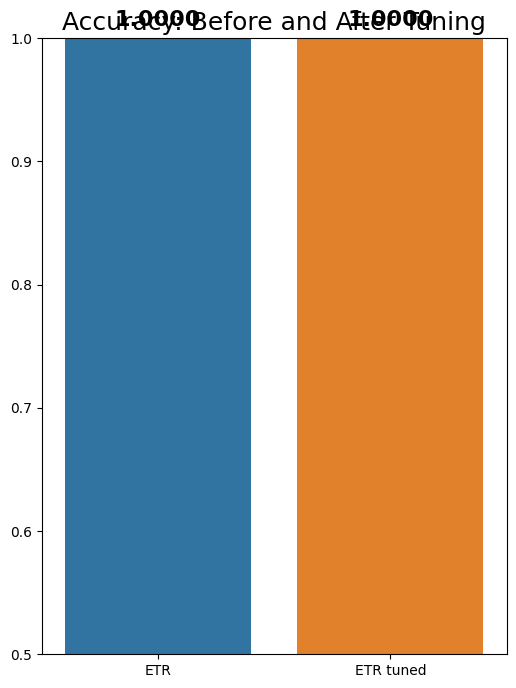

In [54]:
names = np.array(['ETR', 'ETR tuned'])
values = np.array([etr_score, study.best_value])

plt.figure(figsize=(6,8))
plt.title("Accuracy: Before and After Tuning", fontsize=18)
plt.ylim(0.5, 1.0)
bar1 = sns.barplot(x = names, y = values);

for p in bar1.patches:
  _x = p.get_x() + p.get_width() / 2
  _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
  value = '{:.4f}'.format(p.get_height())
  plt.text(_x, _y, value, ha="center", fontsize=16, fontweight = 'bold') 

In [36]:
pickle.dump(clf,open('/content/drive/MyDrive/datapkle/EMG500.pkl','wb'))

In [37]:
# load model from pickle 
model = pickle.load(open('/content/drive/MyDrive/datapkle/EMG500.pkl','rb'))

In [38]:
# get one sample to test 
tt = df1.iloc[0]
X = tt[:-1]
y = tt[-1]
Y_pred = model.predict([X])

In [40]:
print(X)
print(y)

index              846.000000
feature_one          0.000135
feature_two          0.063700
feature_three       -0.001299
feature_four         0.011532
feature_five         0.000133
feature2_one         0.011582
feature2_two         0.364500
feature2_three       0.000243
feature2_four        0.107628
feature2_five        0.011584
feature3_one         0.000202
feature3_two         0.048000
feature3_three       0.005475
feature3_four        0.013121
feature3_five        0.000172
feature4_one         0.001413
feature4_two         0.134200
feature4_three      -0.000053
feature4_four        0.037596
feature4_five        0.001413
feature5_one      8983.823104
feature5_two        96.200000
feature5_three      94.779880
feature5_four        0.773027
feature5_five        0.597571
Name: 0, dtype: float64
1.0


In [41]:
Y_pred , y

(array([1]), 1.0)

In [48]:
tt = df1.iloc[3]
X = tt[:-1]
y = tt[-1]
Y_pred = model.predict([X])
print(X)
print(y)

index             331.000000
feature_one         0.003675
feature_two         0.937500
feature_three      -0.002726
feature_four        0.060567
feature_five        0.003668
feature2_one        0.001611
feature2_two        0.297700
feature2_three     -0.001193
feature2_four       0.040125
feature2_five       0.001610
feature3_one        0.005859
feature3_two        0.825000
feature3_three     -0.015997
feature3_four       0.074863
feature3_five       0.005604
feature4_one        0.000617
feature4_two        0.197200
feature4_three      0.000067
feature4_four       0.024852
feature4_five       0.000618
feature5_one      684.520634
feature5_two       11.100000
feature5_three    -17.266140
feature5_four      19.659052
feature5_five     386.478339
Name: 3, dtype: float64
0.0


In [49]:
Y_pred , y

(array([0]), 0.0)